In [2]:
import pandas as pd
import numpy as np
import cProfile
import re
import seaborn as sns
import vaex as vx
import modin.pandas as mpd
import ray
import dask.dataframe as dd
import dask.array as da
import dask.bag as db
import polars as pl
import io
import pstats
import matplotlib.pyplot as plt
import time


In [3]:
def profile_read(library_name, read_func):
    pr = cProfile.Profile()
    pr.enable()
    df = read_func()
    pr.disable()
    s = io.StringIO()
    ps = pstats.Stats(pr, stream=s).sort_stats('cumulative')
    ps.print_stats()
    stats_str = s.getvalue()
    lines = stats_str.split('\n')
    for line in lines:
        if 'function calls' in line:
            total_time = ps.total_tt
            break
    return total_time, df

def read_pandas():
    return pd.read_csv('cord_19_embeddings_2022-06-02.csv')

def read_modin():
    return mpd.read_csv('cord_19_embeddings_2022-06-02.csv')

def read_dask():
    return dd.read_csv('cord_19_embeddings_2022-06-02.csv')

def read_vaex():
    return vx.from_csv('cord_19_embeddings_2022-06-02.csv')

def read_polars():
    return pl.read_csv('cord_19_embeddings_2022-06-02.csv')
ray.init()

2026-01-18 12:30:05,567	INFO worker.py:2007 -- Started a local Ray instance.


Python version:,3.10.19
Ray version:,2.53.0


In [4]:
def profile_read_modin():
    start_time = time.time()
    chunks = []
    for chunk in mpd.read_csv('cord_19_embeddings_2022-06-02.csv', chunksize=100000):
        chunks.append(chunk)
    df = mpd.concat(chunks)
    end_time = time.time()
    time_taken = end_time - start_time
    return time_taken, df

times = {}
print("Profiling Modin separately...")
try:
    time_taken, df = profile_read_modin()
    times['modin'] = time_taken
    print(f"Modin: {time_taken:.2f} seconds")
except Exception as e:
    times['modin'] = f'Error: {str(e)}'
    print(f"Modin: Error - {str(e)}")


Profiling Modin separately...


Please refer to https://modin.readthedocs.io/en/stable/supported_apis/defaulting_to_pandas.html for explanation.
Reason: `chunksize` parameter is not supported
(pid=gcs_server) [2026-01-18 12:30:34,523 E 46924 9132] (gcs_server.exe) gcs_server.cc:303: Failed to establish connection to the event+metrics exporter agent. Events and metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(raylet) [2026-01-18 12:30:37,392 E 44988 39100] (raylet.exe) main.cc:1032: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


Modin: 270.87 seconds


In [5]:

libraries = {
    'pandas': read_pandas,
    'dask': read_dask,
    'vaex': read_vaex,
    'polars': read_polars
}

for lib, func in libraries.items():
    print(f"Profiling {lib}...")
    try:
        time_taken, df = profile_read(lib, func)
        times[lib] = time_taken
        print(f"{lib}: {time_taken:.2f} seconds")
    except MemoryError:
        times[lib] = 'Memory Error'
        print(f"{lib}: Memory Error")
    except Exception as e:
        times[lib] = f'Error: {str(e)}'
        print(f"{lib}: Error - {str(e)}")

Profiling pandas...
pandas: 206.90 seconds
Profiling dask...
dask: 0.47 seconds
Profiling vaex...
vaex: 204.95 seconds
Profiling polars...
polars: 15.51 seconds


In [6]:
results_df = pd.DataFrame(list(times.items()), columns=['Library', 'Time (seconds)'])
results_df

,Library,Time (seconds)
0,modin,270.869159
1,pandas,206.896433
2,dask,0.471202
3,vaex,204.954174
4,polars,15.514542


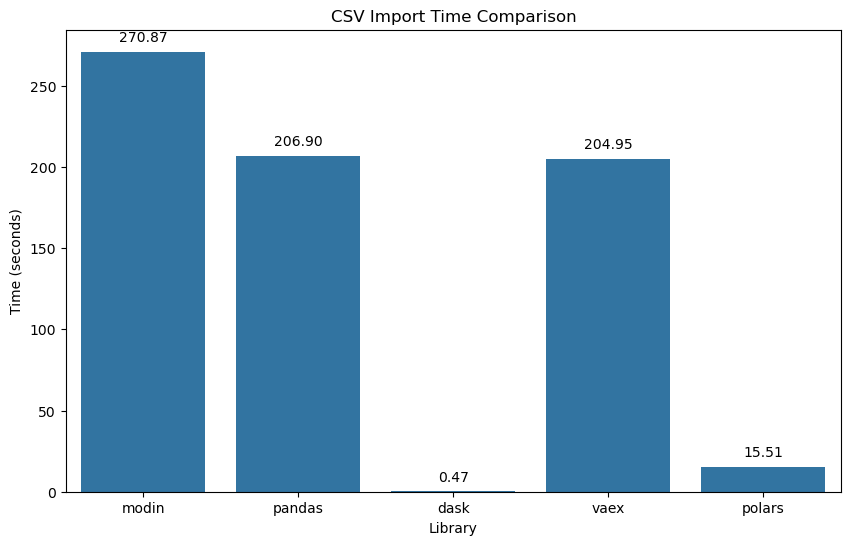

In [7]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=results_df, x='Library', y='Time (seconds)')
plt.title('CSV Import Time Comparison')
plt.ylabel('Time (seconds)')

for p in ax.patches:
    if isinstance(p.get_height(), (int, float)):
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom', xytext=(0, 5), textcoords='offset points')

plt.show()